In [5]:
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

In [6]:
torch.cuda.is_available()

True

# Network

In [91]:
class ResNetLike(nn.Module):
  def __init__(self, depth_n):
    super(ResNetLike, self).__init__()
    self.start = nn.Sequential(OrderedDict([('conv0', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)),
                ('relu0', nn.LeakyReLU()),
                ('bn0', nn.BatchNorm2d(16))]))
    i_list = [0, 1, 2]
    self.repetitions = len(i_list * 2 * depth_n)
    self.block1_list = nn.ModuleList([])
    self.block2_list = nn.ModuleList([])
    self.identity_upscale_list = nn.ModuleList([])
    for i in i_list:
        for n in range(2 * depth_n):
            i_channels = 16 * (2 ** i)
            if n == ((2 * depth_n) -1) and i != i_list[-1]:
                last_channels = 16 * (2 ** (i+1))
            else:
                last_channels = i_channels
            b1 = [nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
                  nn.LeakyReLU(),
                  nn.BatchNorm2d(i_channels),
                  nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
                  nn.LeakyReLU(),
                  nn.BatchNorm2d(i_channels)]
            b2 = [nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
                  nn.LeakyReLU(),
                  nn.BatchNorm2d(i_channels),
                  nn.Conv2d(in_channels=i_channels, out_channels=last_channels, kernel_size=3, stride=2, padding=1),
                  nn.LeakyReLU(),
                  nn.BatchNorm2d(last_channels)]
            self.block1_list.append(nn.Sequential(*b1))
            self.block2_list.append(nn.Sequential(*b2))
            self.identity_upscale_list.append(nn.Conv2d(in_channels=i_channels, out_channels=last_channels, kernel_size=3, stride=2, padding=1))
    self.end = nn.Sequential(*[nn.Linear(16 * (2 ** 2), 10), nn.Softmax(dim=10)])
                                           

  def forward(self, x):
    y = self.start(x)
    for i in range(self.repetitions):
        identity = y
        y = self.block1_list[i](y)
        y += identity
        identity = y
        y = self.block2_list[i](y)
        y += self.identity_upscale_list[i](identity)
        print(y.shape)
    return self.end(y.reshape([-1,64]))
    

# Dataset

In [10]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

In [11]:
train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)

In [51]:
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
])

batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 32, 32]) torch.Size([32])


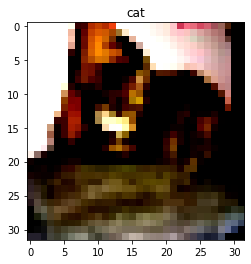

In [52]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)
plt.imshow(x[0].permute(1, 2, 0))
plt.title(classes[y[0].item()])
plt.show()

# Train one iteration

In [53]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 32, 32])

In [92]:
resnet_model = ResNetLike(depth_n=1)
resnet_model.cuda()
# fc_optim = optim.SGD(fc_model.parameters(), lr=1e-3, momentum=0.9)
fc_optim = optim.Adam(resnet_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

batch = next(iter(train_loader))
x, y = batch
x, y = x.cuda(), y.cuda()
output = resnet_model(x)
loss = criterion(output, y)
loss.backward()
fc_optim.step()

torch.Size([32, 16, 16, 16])
torch.Size([32, 32, 8, 8])
torch.Size([32, 32, 4, 4])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 1, 1])
torch.Size([32, 64, 1, 1])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 10)

# Train

In [ ]:
def train(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
  
  use_test = False
  if isinstance(data, DataLoader):
    train_loader = data
  elif isinstance(data, tuple):
    if len(data) == 2:
      train_loader, test_loader = data
      if not isinstance(train_loader, DataLoader):
        raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
      if not isinstance(test_loader, DataLoader):
        raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
      use_test = True
    else:
      raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
  
  criterion = nn.CrossEntropyLoss()
  model.train()
  losses = []
  batch_total = len(train_loader)

  for epoch in range(max_epochs):
    samples_total = 0
    samples_correct = 0
    for batch_idx, batch in enumerate(train_loader):
      x, y = batch
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()
      
      yhat = torch.argmax(output, dim=1)

      samples_total += len(y)
      samples_correct += torch.sum(yhat == y)
      losses.append(loss.item())


      if batch_idx % 50 == 0:
        acc = float(samples_correct) / float(samples_total)

        if use_test:
          model.eval()

          test_x, test_y = next(iter(test_loader))
          if cuda:
            test_x, test_y = test_x.cuda(), test_y.cuda()
          test_output = model(test_x)
          test_loss = criterion(test_output, test_y)

          test_yhat = torch.argmax(test_output, dim=1)
          test_acc = float(torch.sum(test_yhat == test_y)) / float(len(test_y))
          
          model.train()

          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Acc: {acc:.2%} Test loss: {test_loss:.6f} Test acc: {test_acc:.2%}')
        else:
          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Acc: {acc:.2%}')

  return losses

In [ ]:
cnn_model = cnn_model.cuda()
cnn_optim = optim.Adam(cnn_model.parameters(), lr=1e-3)
cnn_losses = train(cnn_model, cnn_optim, (train_loader, test_loader), max_epochs=10)